## Import libraries

In [15]:
import os

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
import shutil
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Set the random seeds

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Load the data, Split the data into 80% training and 20% validation and save into directory

In [17]:
%%capture
image_dir = './Data/'
data_dir = './'

train_size = 0.8
val_size = 0.2

for root, dirs, files in os.walk(image_dir):
    if len(files) > 0:
        train_files, val_files = train_test_split(files, test_size=(1 - train_size), random_state=42)
        for split_name,files in zip(["train","val"],[train_files,val_files]):
            output_dir = os.path.join(data_dir, split_name, os.path.relpath(root, image_dir))
            os.makedirs(output_dir, exist_ok=True)
            for file in files:
                src = os.path.join(root, file)
                dst = os.path.join(output_dir, file)
                shutil.move(src, dst)

In [18]:
#train and validation transforms
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
])

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
])

train_set = torchvision.datasets.ImageFolder("train", transform=train_transform)
val_set = torchvision.datasets.ImageFolder("val", transform=val_transform)

# Define data loaders
train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
val_loader = DataLoader(val_set,batch_size=32,shuffle=False)

Train set
glioma: 720 / meningioma: 730 /normal: 350 / pituitary: 675


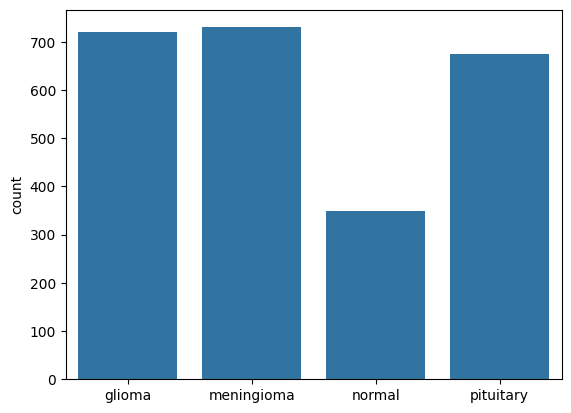

In [19]:
# train set distribution
counter = []
x_g = 0
x_m = 0
x_n = 0
x_p = 0

for i in train_set:
    if i[1] == 0:
        counter.append("glioma")
        x_g += 1
    elif i[1] == 1:
        counter.append("meningioma")
        x_m += 1
    elif i[1] == 2:
        counter.append("normal")
        x_n += 1
    else:
        counter.append("pituitary")
        x_p += 1

print('Train set')
print('glioma:', x_g, '/ meningioma:', x_m,'/normal:', x_n, '/ pituitary:', x_p)
sns.countplot(x=counter);

Train set
glioma: 181 / meningioma: 183 /normal: 88 / pituitary: 169


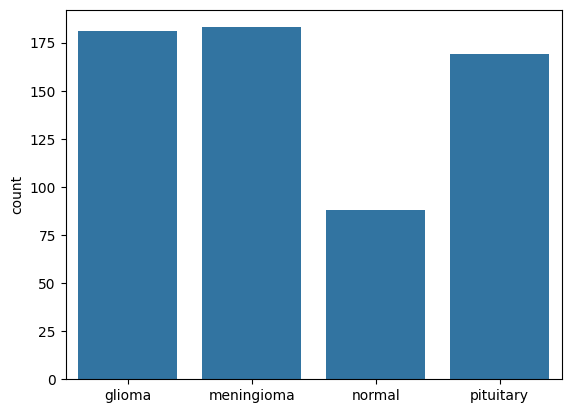

In [20]:
# validation set distribution
counter = []
x_g = 0
x_m = 0
x_n = 0
x_p = 0

for i in val_set:
    if i[1] == 0:
        counter.append("glioma")
        x_g += 1
    elif i[1] == 1:
        counter.append("meningioma")
        x_m += 1
    elif i[1] == 2:
        counter.append("normal")
        x_n += 1
    else:
        counter.append("pituitary")
        x_p += 1

print('Train set')
print('glioma:', x_g, '/ meningioma:', x_m,'/normal:', x_n, '/ pituitary:', x_p)
sns.countplot(x=counter);

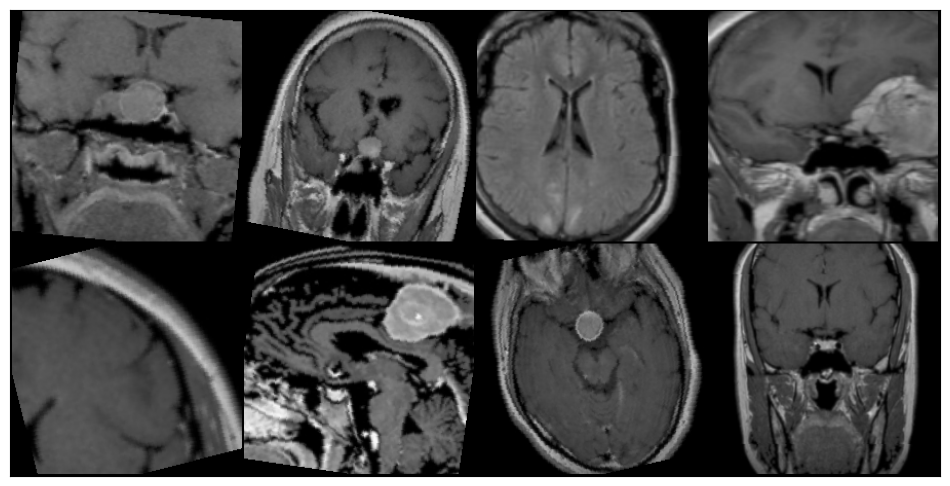

In [21]:
stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dltrain_loader):
    for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(torchvision.utils.make_grid(denorm_images[:8], nrow=4).permute(1, 2, 0).clamp(0,1))
        break
        
show_batch(train_loader)

In [22]:
# Carregue o modelo pré-treinado AlexNet
model = models.alexnet(pretrained=True)

# Substitua a camada totalmente conectada (classificador) para se adequar ao seu problema de classificação (4 classes)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

metrics = {
    'train': {
         'loss': [], 'accuracy': []
    },
    'val': {
         'loss': [], 'accuracy': []
    },
}

#Train model
train_loss=[]
train_accuary=[]
valid_loss=[]
valid_accuary=[]

num_epochs = 20   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0
    # load a batch data of images
    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        # forward inputs and get output
        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()
            outputs=model(image)
            _, preds = torch.max(outputs, 1)
            loss=criterion(outputs,label)
            if loss.requires_grad:
                loss.backward()
            return loss
        optimizer.step(closure)
        # only for diagnostics
        outputs=model(image)
        loss=criterion(outputs,label)
        _, preds = torch.max(outputs, 1)
        #running_loss +=loss.data.item()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == label.data).item()
    epoch_loss = running_loss / len(train_set)
    epoch_acc = running_corrects / len(train_set) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for image, label in val_loader:
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, label)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == label.data).item()
        epoch_loss = running_loss / len(val_set)
        epoch_acc = running_corrects / len(val_set) * 100.
        # Append result
        valid_loss.append(epoch_loss)
        valid_accuary.append(epoch_acc)
        # Print progress
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #1] Loss: 0.0255 Acc: 67.8384% Time: 14.9173s
[Validation #1] Loss: 0.0200 Acc: 73.2689% Time: 17.0222s
Epoch 1 running
[Train #2] Loss: 0.0195 Acc: 74.8687% Time: 33.2801s
[Validation #2] Loss: 0.0153 Acc: 84.5411% Time: 35.4066s
Epoch 2 running
[Train #3] Loss: 0.0168 Acc: 78.5051% Time: 51.4843s
[Validation #3] Loss: 0.0115 Acc: 88.2448% Time: 53.6118s
Epoch 3 running
[Train #4] Loss: 0.0148 Acc: 81.4141% Time: 69.5385s
[Validation #4] Loss: 0.0103 Acc: 88.5668% Time: 71.7526s
Epoch 4 running
[Train #5] Loss: 0.0139 Acc: 83.5960% Time: 87.4842s
[Validation #5] Loss: 0.0129 Acc: 85.6683% Time: 89.7307s
Epoch 5 running
[Train #6] Loss: 0.0127 Acc: 85.2121% Time: 105.6409s
[Validation #6] Loss: 0.0091 Acc: 91.3043% Time: 107.7229s
Epoch 6 running
[Train #7] Loss: 0.0122 Acc: 85.1313% Time: 123.5666s
[Validation #7] Loss: 0.0065 Acc: 94.6860% Time: 125.6871s
Epoch 7 running
[Train #8] Loss: 0.0118 Acc: 86.0202% Time: 141.4893s
[Validation #8] Loss: 0.0080 Acc: 91.

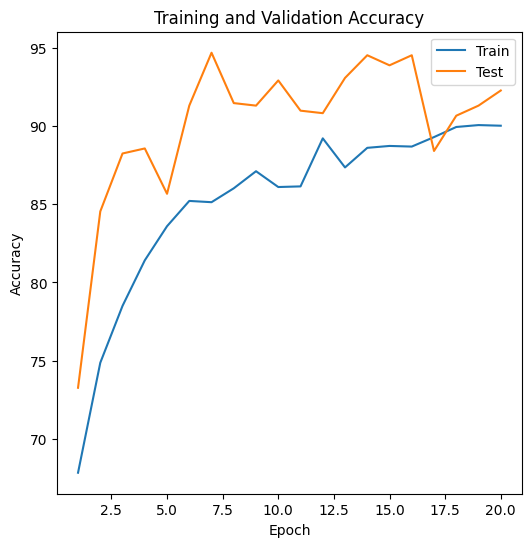

In [24]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary)
plt.plot(np.arange(1,num_epochs+1), valid_accuary)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Training and Validation Accuracy')
plt.show()

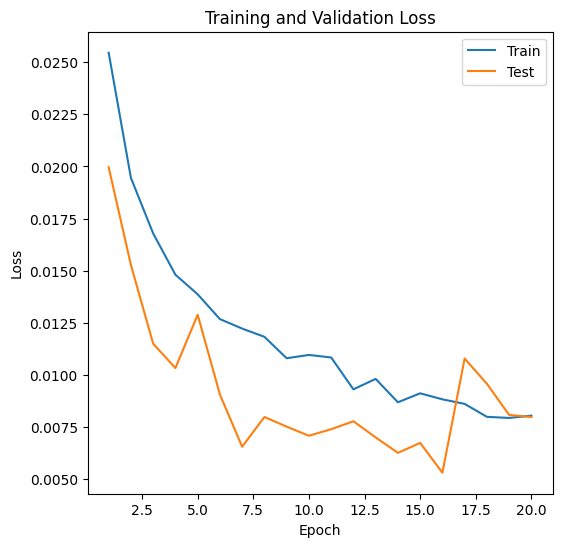

In [25]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_loss)
plt.plot(np.arange(1,num_epochs+1), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Training and Validation Loss')
plt.show()

In [26]:
y_true = []
y_pred = []

for data in val_loader:
    image,label=data[0].to(device),data[1]
    y_true.extend(label.numpy())

    outputs=model(image)

    _, predicted = torch.max(outputs, 1)
    y_pred.extend(predicted.cpu().numpy())

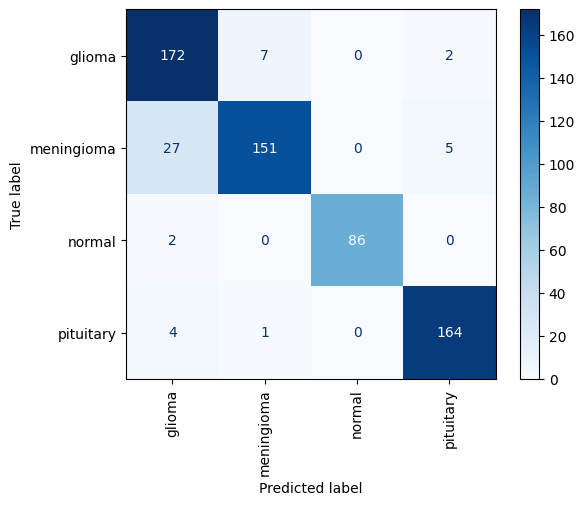

In [27]:
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_labels = ['glioma','meningioma', 'normal', 'pituitary']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues,xticks_rotation="vertical")
plt.show()

In [28]:
# Generate a classification report
  
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       181
           1       0.95      0.83      0.88       183
           2       1.00      0.98      0.99        88
           3       0.96      0.97      0.96       169

    accuracy                           0.92       621
   macro avg       0.94      0.93      0.93       621
weighted avg       0.93      0.92      0.92       621

